Tabel Hujan Efektif Jam-jaman
   Jam ke-  Hujan Rencana   Hujan Rencana (ARF)  Infiltrasi  Hujan Efektif
0        1           6.645              6.44565    6.126275       0.319376
1        2          13.290             12.89130   12.024595       0.866705
2        3          79.740             77.34780   33.385821      43.961978
3        4          21.264             20.62608    3.998700      16.627380
4        5           7.974              7.73478    1.272745       6.462035
5        6           3.987              3.86739    0.588882       3.278508
Tabel Hujan Efektif Jam-jaman kumulatif
   Jam ke-  Hujan Rencana   Hujan Rencana (ARF)  Infiltrasi  Hujan Efektif
0        1           6.645              6.44565        6.45           0.00
1        2          19.935             19.33695       19.11           0.23
2        3          99.675             96.68475       54.26          42.42
3        4         120.939            117.31083       58.47          58.84
4        5         128.913    

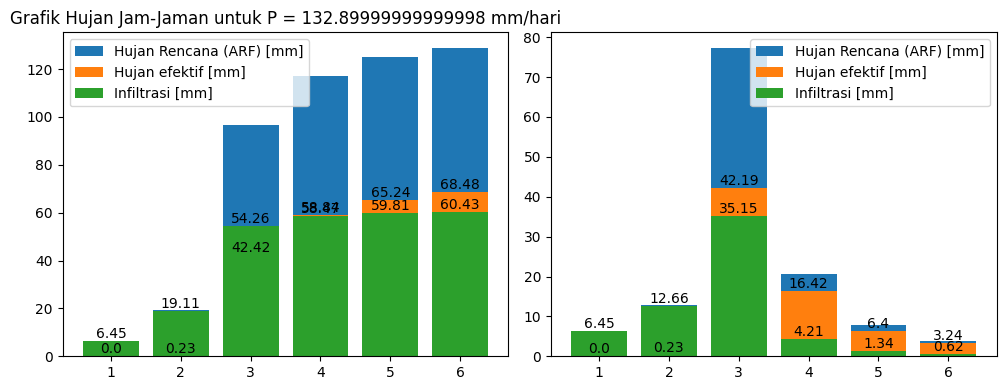

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Fungsi untuk menghitung limpasan berdasarkan metode CN
def calculate_limpasan(P, ARF, CN, Im):
    PSA007kum = [0.05, 0.15, 0.75, 0.91, 0.97, 1]
    PSA007 = np.diff(PSA007kum, prepend=0)
    Pjam = PSA007 * P
    Pjam_cum = np.cumsum(Pjam)
    # Tanpa Area Reduction F
    Pjam_ARF = Pjam * ARF  # Hujan Jam Jaman dikali dengan area reduction factor
    Pjam_ARF_cum = np.cumsum(Pjam_ARF)
    absis = np.arange(1, len(Pjam_ARF) + 1)  # Membuat array sumbu x (jumlah jam)

    P = np.array(Pjam_ARF)
    Pkum = np.array(Pjam_ARF_cum)

    def limpCN(CN, P):  # membuat fungsi dengan nilai CN dan Hujan
        '''P dalam mm, limp dalam mm'''
        S = 1000 / CN - 10  # persamaan hubungan storage dengan nilai CN
        k = 0.2  # where K is varied between 0-0.26 (springer et al.), K=0.2 is recommended by SCS
        Pkum = []  # membuat array hujan kumulatif
        Ptot = 0  # mendefinisikan hujan total =0
        for i in range(len(P)):  # membuat nilai i sejumlah hujan jam-jaman yang diberikan
            Ptot += P[i] / 25.4  # Hujan total baru adalah hujan total sebelumnya di tambah hujan pada jam i (diubah dari mm ke inch)
            Pkum.append(Ptot)  # Menyimpan hujan kumulatif ke dalam array Pkum
        reff = []  # membua t array hujan efektif
        infil = []  # membuat array infiltrasi
        Iab = []  # membuat array Inital Abstraction
        reffkumseb = 0  # memberikan nilai hujan efektif sebelumnya
        Faseb = 0  # memberikan nilai infiltrasi sebelumnya
        for i in range(len(Pkum)):  # membuat nilai i sejumlah Hujan kumulatif
            Ia = k * S  # initial abtraction koefisien x dengan storage
            if (Pkum[i] > Ia):  # Cek apakah nilai hujan kumulatif pada jam tersebut lebih besar dari initial abtraction
                Ia = Ia  # jika hujan kumulatif > Ia maka berikan nilai Ia adalah Ia
                Iab.append(Ia)
            else:
                Ia = Pkum[i]  # jika hujan kumulatif < atau = Ia maka berikan nilai Ia adalah hujan kumulatif pada jam tersebut
                Iab.append(Ia)
            Fa = S * (Pkum[i] - Ia) / (Pkum[i] - Ia + S)  # continuing abstraction (Fa) = storage x (hujan kumulatif - initial abstraction) / (hujan kumulatif - initial abstraction + storage)
            infil.append(Fa - Faseb)  # memasukan nilai infiltrasi yaitu continuing abstraction (Fa) - continuing abstraction sebelumnya (Fa)
            Faseb = Fa  # update nilai continuing abstraction (Fa) sebelumnya
            reffkum = Pkum[i] - Ia - Fa  # hujan efektif kumulatif = Hujan kumulatif - Ia -Fa
            reff.append(reffkum - reffkumseb)  # memasukan nilai hujan efektif = hujan efektif kumulatif - hujan efektif kumulatif sebelumnya
            reffkumseb = reffkum  # update nilai hujan kumulatif
        infil = np.array(infil) * 25.4  # membuat array infiltrasi dan mnejadikan dari inch ke mm
        reff = np.array(reff) * 25.4  # membuat array hujan  dan mnejadikan dari inch ke mm
        return (reff, infil, Iab)  # Menyimpan fungsi hujan efektif dan infiltrasi

    reff, infil, Iab = (limpCN(CN, P))  # Memanggil fungsi limpasan CN
    Iab = np.array(Iab)
    Iab = Iab * 25.4
    reff_kum = (np.cumsum(np.round(reff, 2)))
    infill_kum = np.round((Pkum - reff_kum), 2)

    P = np.diff(Pkum, prepend=0)
    infill = np.diff(infill_kum, prepend=0) * ((100 - Im) / 100)
    reff = P - infill

    # Menyimpan hasil perhitungan dalam DataFrame
    refftab = {
        'Jam ke-': absis,
        'Hujan Rencana ': Pjam,
        'Hujan Rencana (ARF)': P,
        'Infiltrasi': infill,
        'Hujan Efektif': reff,
        #'Nilai CN': CN,
        #'Nilai Impervious (%)': Im,
    }
    dfreff = pd.DataFrame(refftab)
    print('Tabel Hujan Efektif Jam-jaman')
    print(dfreff)

    reffkumtab = {
        'Jam ke-': absis,
        'Hujan Rencana ': Pjam_cum,
        'Hujan Rencana (ARF)': Pkum,
        'Infiltrasi': infill_kum,
        'Hujan Efektif': reff_kum,
        #'Nilai CN': CN,
        #'Nilai Impervious (%)': Im,
    }
    dfreffkum = pd.DataFrame(reffkumtab) 
    print('Tabel Hujan Efektif Jam-jaman kumulatif')
    print(dfreffkum)
    # Plot    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    #plt.bar(absis,Pjam_cum,label="P [mm]")
    axes[0].bar(absis,Pkum,label="Hujan Rencana (ARF) [mm]")
    axes[0].bar(absis,reff_kum,label="Hujan efektif [mm]")
    axes[0].bar(absis,infill_kum,label="Infiltrasi [mm]")
    axes[0].set_title('Grafik Hujan Jam-Jaman untuk P = {} mm/hari'.format(np.sum(P)/ARF))
    for i in range(len(reff_kum)):
        axes[0].text(absis[i], reff_kum[i], str(round(reff_kum[i], 2)), ha='center', va='bottom')
        axes[0].text(absis[i], infill_kum[i], str(round(infill_kum[i], 2)), ha='center', va='bottom')
    axes[0].legend();
    
    
    P = np.diff(Pkum, prepend=0)
    reff= np.diff(reff_kum, prepend=0)
    infill= np.diff(infill_kum, prepend=0)
    #plt.bar(absis,Pjam_cum,label="P [mm]")
    axes[1].bar(absis,P,label="Hujan Rencana (ARF) [mm]")
    axes[1].bar(absis,reff,label="Hujan efektif [mm]")
    axes[1].bar(absis,infill,label="Infiltrasi [mm]")
    for i in range(len(reff)):
        axes[1].text(absis[i], reff[i], str(round(reff[i], 2)), ha='center', va='bottom')
        axes[1].text(absis[i], infill[i], str(round(infill[i], 2)), ha='center', va='bottom')
    axes[1].legend();
    plt.tight_layout()
    plt.show()
    plt.close()



# Masukkan data pengguna
P = 132.9
ARF = 0.97
CN = 77.11
Im = 5.019
calculate_limpasan(P, ARF, CN, Im)


